In [15]:
%reset -f

In [1]:
# ~~~~~~~~~~~~~~ Libraries
import sys, os
import mne # Python package for processing and analyzing electrophysiological data
import numpy as np
from glob import glob # look for all the pathnames matching a specified pattern according to the rules
import matplotlib.pyplot as plt
from mne.preprocessing import ICA # ICA (Independent Component Analysis) algorithm, which is for artifact removal
import json
import re

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.stats import permutation_test
import matplotlib.pyplot as plt
from itertools import combinations

import pandas as pd
import seaborn as sns
import pickle

# Average time series for one channel

Reading /u/kazma/MINT/data/interim/visual/sub-01_ses-01/epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
1260 matching events found
No baseline correction applied
0 projection items activated
sub-01_ses-01 is analyzed
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG Channels: ['Fz', 'F3', 'F7', 'FC5', 'POz', 'C3', 'T7', 'TP9', 'CP5', 'P7', 'P3', 'Pz', 'O1', 'O2', 'P8', 'P4', 'CP6', 'TP10', 'T8', 'C4', 'Oz', 'FC6', 'F8', 'F4', 'FC4', 'CP4', 'FC3', 'CP3']
Number of EEG Channels: 28


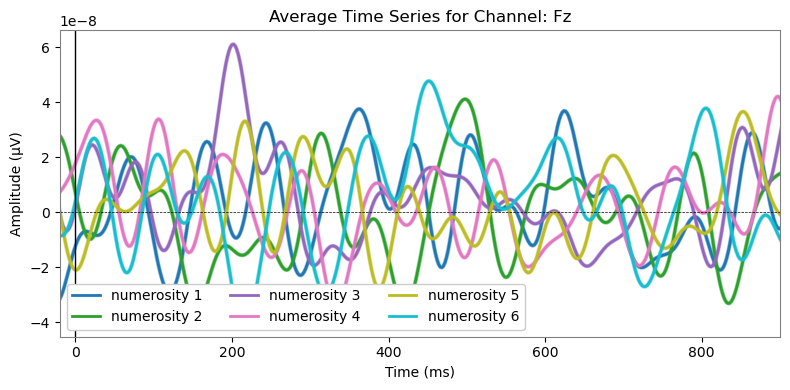

Reading /u/kazma/MINT/data/interim/visual/sub-02_ses-01/epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
1260 matching events found
No baseline correction applied
0 projection items activated
sub-02_ses-01 is analyzed
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG Channels: ['Fz', 'F3', 'F7', 'F9', 'FC5', 'POz', 'C3', 'T7', 'TP9', 'CP5', 'P7', 'P3', 'Pz', 'O1', 'O2', 'P8', 'P4', 'CP6', 'TP10', 'T8', 'C4', 'Oz', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'FC4', 'CP4', 'FC3', 'CP3']
Number of EEG Channels: 31


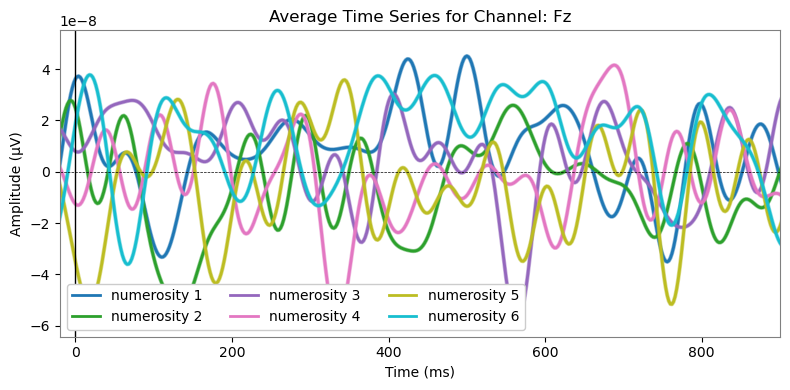

Reading /u/kazma/MINT/data/interim/visual/sub-03_ses-01/epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
1260 matching events found
No baseline correction applied
0 projection items activated
sub-03_ses-01 is analyzed
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG Channels: ['Fz', 'F3', 'F7', 'F9', 'FC5', 'POz', 'C3', 'T7', 'TP9', 'CP5', 'P7', 'P3', 'Pz', 'O1', 'O2', 'P8', 'P4', 'CP6', 'TP10', 'T8', 'C4', 'Oz', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'FC4', 'CP4', 'FC3', 'CP3']
Number of EEG Channels: 31


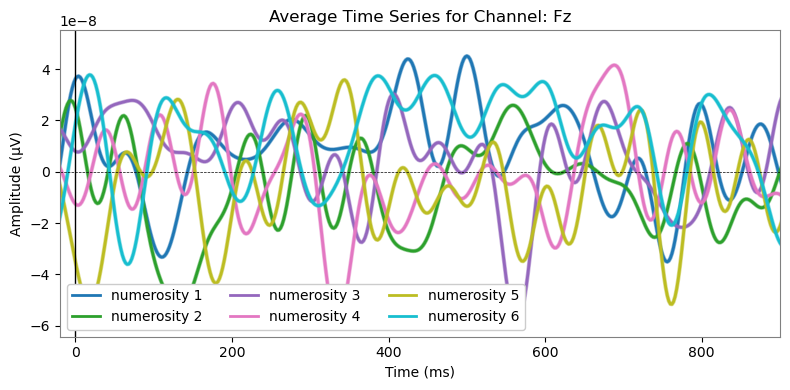

In [15]:

# Set the working directory
path = "/u/kazma/MINT/data/interim/visual"
sub_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
sub_folders_sorted = sorted(sub_folders, key=lambda x: int(re.search(r'\d+', x).group())) # Sort the folders based on the numeric part after "sub-"



for sub_loop in sub_folders_sorted:

    # subject folder 
    sub_filename = os.path.join(path, sub_loop, 'epochs-epo.fif')

    # Load epochs
    epochs = mne.read_epochs(sub_filename, preload=True)
    print(f"{sub_loop} is analyzed")

    eeg_channels = epochs.pick_types(eeg=True).ch_names
    print("EEG Channels:", eeg_channels)
    print("Number of EEG Channels:", len(eeg_channels))
    
    # Get the condition names
    condition_names = list(epochs.event_id.keys())
    evoked_list = []

    # Compute the averaged epoch for each condition and each channel
    for condition in condition_names:
        evoked = epochs[condition].average()  # Average the epochs for the condition
        evoked_list.append(evoked)

    # Store 6 vectors, representing averaged vector for each condition
    averaged_data = {}

    # Specify the channel to plot (e.g., channel name 'Cz')
    channel_name = 'Fz'  # Replace with the channel of your choice

    # Figure
    plt.figure(figsize=(8, 4))

    # Define colors for the conditions
    colors = plt.cm.tab10(np.linspace(0, 1, 6))

    for i, evoked in enumerate(evoked_list):
        # Extract data for the specified channel
        channel_index = evoked.ch_names.index(channel_name)  # Get index of the channel
        channel_data = evoked.data[channel_index]  # Get the data for the specific channel
        times = evoked.times * 1000  # Convert time to milliseconds

        # Store the data
        averaged_data[condition_names[i]] = channel_data
        
        # Plot the channel data
        plt.plot(times, channel_data, color=colors[i], linewidth=3, alpha=0.5) 
        plt.plot(times, channel_data, label=condition_names[i], color=colors[i], linewidth=2)  # Plot time series

    # Customize the plot
    plt.title('Average Time Series for Channel: ' + channel_name)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0
    plt.axvline(0, color='black', linestyle='-', linewidth=1)  # Add a vertical line at t=0
    plt.xlim(-20, 900)  # Set x-axis limits
    # plt.ylim(-2.0e-8, 2.0e-8)  # Set y-axis limits
    plt.legend(ncol=3, loc='lower left', framealpha=1)

    # Set the box line color to gray
    ax = plt.gca()
    ax.spines['top'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    plt.tight_layout()
    plt.show()



In [14]:
# Get list of EEG channel names
eeg_channels = epochs.pick_types(eeg=True).ch_names
print("EEG Channels:", eeg_channels)
print("Number of EEG Channels:", len(eeg_channels))
# Plot the sensor locations for the EEG channels
# epochs.plot_sensors(kind='topomap', show_names=True)
print(epochs.get_data().shape[1])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG Channels: ['Fz', 'F3', 'F7', 'F9', 'FC5', 'POz', 'C3', 'T7', 'TP9', 'CP5', 'P7', 'P3', 'Pz', 'O1', 'O2', 'P8', 'P4', 'CP6', 'TP10', 'T8', 'C4', 'Oz', 'FC6', 'F10', 'F8', 'F4', 'Fp2', 'FC4', 'CP4', 'FC3', 'CP3']
Number of EEG Channels: 31
31


# Cross-validation schema (LOOCV)

In [ ]:
# Set the working directory
path = "/u/kazma/MINT/data/interim/visual"
sub_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
sub_folders_sorted = sorted(sub_folders, key=lambda x: int(re.search(r'\d+', x).group())) # Sort the folders based on the numeric part after "sub-"


# SUB_LOOP
for subject in sub_folders_sorted:

    # subject folder 
    sub_filename = os.path.join(path, subject, 'epochs-epo.fif')

    # Load epochs
    epochs = mne.read_epochs(sub_filename, preload=True)


    # Get the information about the data
    conditions = list(epochs.event_id.keys())
    n_conditions = len(conditions)
    n_trials = len(epochs)
    n_channels = epochs.get_data().shape[1]
    n_samples = epochs.get_data().shape[2]
    min_time = epochs.times[0]*1000   # First time point in milli seconds
    max_time = epochs.times[-1]*1000    # Last time point in milli seconds


    # list for avg accuracy for each time window
    all_decoding_accuracy = [] 

    # number of samples for each window
    window_size = 5 # 1 sample = 2ms, 5 samples = 10 ms
    n_splits = 7 # number of folds

    # Window loop start
    for start in range(0, n_samples, window_size): # Loop over the epoch in steps of `window_size` to extract each 5-sample window
        # Check if there are enough samples left for a full window
        if start + window_size <= n_samples:

            # Initialize the decoding dictionary with each condition containing a list of flattened sample windows
            decoding_dict = {}

            for condition in conditions:
                x = epochs[condition] 
                x = x.get_data() # the shape: (n_trials, n_channels, n_times)
                x = x[:,:,start:start + window_size] # 5 sample is a window size
                x = x.reshape(x.shape[0], -1)
                decoding_dict[condition] = x


            # Dictionary to store decoding results for each pair
            pairwise_decoding_accuracies = {}

            for i in range(n_conditions):
                for j in range(i + 1, n_conditions):

                    cond1 = conditions[i]
                    cond2 = conditions[j]
                        
                    # Classification
                    data_cond1 = decoding_dict[cond1]
                    data_cond2 = decoding_dict[cond2]
                    data = np.vstack((data_cond1, data_cond2))
                    labels = np.hstack((np.zeros(len(data_cond1)), np.ones(len(data_cond2))))

                    # Set cross-validation
                    cv = StratifiedKFold(n_splits=n_splits) # StratifiedKFold ensures that each fold has a proportional representation of both classes, so each fold maintains a 50:50 balance of numerosity 1 and numerosity 2 trials.

                    # Time-resolved decoding storage
                    decoding_accuracies = []

                    # Cross-validation for this time point
                    for train_idx, test_idx in cv.split(data, labels):
                        X_train, X_test = data[train_idx], data[test_idx] # the EEG data for training and testing.
                        y_train, y_test = labels[train_idx], labels[test_idx] # corresponding labels for the training and testing data.
                        
                        clf = SVC(kernel='linear') # initializes a support vector machine (SVM) classifier with a linear kernel.
                        clf.fit(X_train, y_train) # trains the classifier on the training data (X_train) with labels (y_train).
                        y_pred = clf.predict(X_test) 
                        decoding_accuracies.append(accuracy_score(y_test, y_pred)) # calculates the classification accuracy by comparing the true labels (y_test) with the predicted labels (y_pred).

                    avg_accuracy = np.mean(decoding_accuracies)
                    # Store the average accuracy for the condition pair
                    pairwise_decoding_accuracies[(cond1, cond2)] = avg_accuracy

                    print(f"Average accuracy for {cond1} vs {cond2} in time points {start + window_size}: {avg_accuracy:.2f}")


        # Average accuracy for this time point across CV folds
        all_decoding_accuracy.append(pairwise_decoding_accuracies)
        print(f"Time point {start + window_size} is done")



# ~~~~~~~~~~~~~~~~ Accuracy matrix

    # List to store the resulting accuracy matrices
    all_accuracy_matrices = []

    # Iterate through each dictionary in 'all_decoding_accuracy'
    for idx, x in enumerate(all_decoding_accuracy):
        # Extract all unique conditions
        conditions = sorted(set(key[0] for key in x.keys()).union(set(key[1] for key in x.keys())))
        n_conditions = len(conditions)

        # Create a dictionary to map conditions to matrix indices
        condition_idx = {condition: idx for idx, condition in enumerate(conditions)}

        # Initialize a square matrix with NaN values (for easier filling)
        accuracy_matrix = np.full((n_conditions, n_conditions), np.nan)

        # Fill the matrix with accuracies
        for (cond1, cond2), accuracy in x.items(): # e.g., 'cond1' = 'numerosity 1' and 'cond2' = 'numerosity 2'
            i, j = condition_idx[cond1], condition_idx[cond2]
            accuracy_matrix[i, j] = accuracy
            accuracy_matrix[j, i] = accuracy  # Ensuring symmetry

        # Convert to DataFrame for readability
        accuracy_df = pd.DataFrame(accuracy_matrix, index=conditions, columns=conditions)
        
        # Store the DataFrame in the list
        all_accuracy_matrices.append(accuracy_df)

        # Optionally print each matrix to verify (can remove if not needed)
        print(f"Decoding Accuracy Matrix for entry {idx + 1}:")
        print(accuracy_df)
        print("\n")

    # Now 'all_accuracy_matrices' contains 110 DataFrames, each corresponding to an accuracy matrix for a given dictionary.


    # Save the list of accuracy matrices to a pickle file
    save_folder = f"/u/kazma/MINT/data/processed/visual/{subject}"
    save_path = os.path.join(save_folder, "all_accuracy_matrices.pkl")
    with open(save_path, "wb") as f:
        pickle.dump(all_accuracy_matrices, f)
    print(f"{subject}: matrices saved in 'all_accuracy_matrices.pkl'")


### accuracy matrix visualization

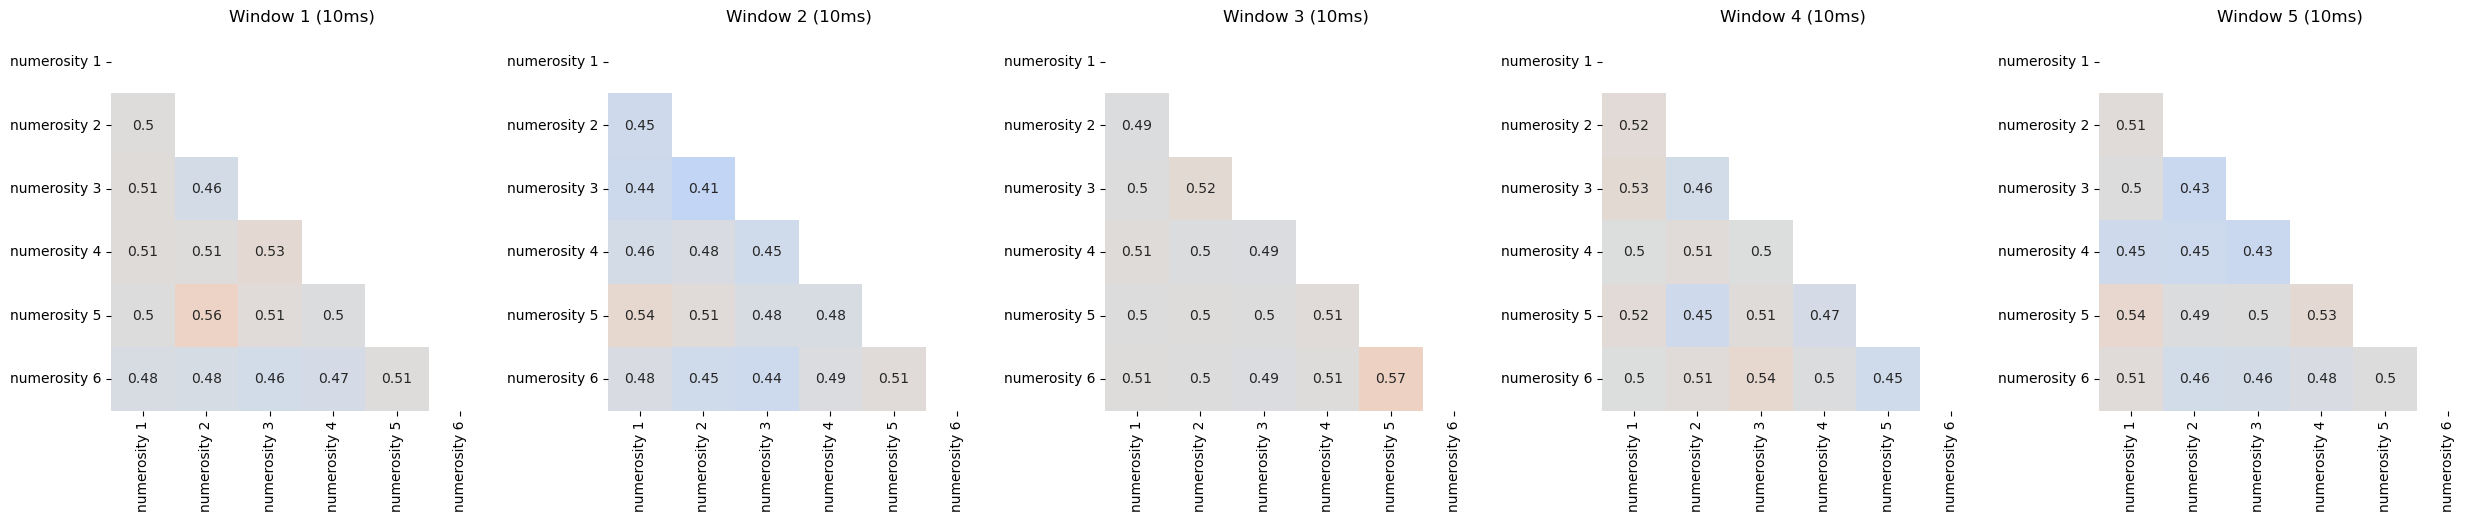

In [24]:
# Select matrices to visualize (for example, the first 5 matrices)
num_matrices_to_plot = 5  # Adjust as needed
selected_matrices = all_accuracy_matrices[:num_matrices_to_plot]

# Plot each selected accuracy matrix
fig, axes = plt.subplots(1, num_matrices_to_plot, figsize=(5 * num_matrices_to_plot, 5))
for i, accuracy_df in enumerate(selected_matrices):
    mask = np.triu(np.ones_like(accuracy_df, dtype=bool))
    sns.heatmap(accuracy_df, ax=axes[i], annot=True, cmap="coolwarm", cbar=False, square=True,
                vmin=0, vmax=1, mask=mask)
    axes[i].set_title(f"Window {i + 1} (10ms)")

plt.tight_layout()
plt.show()

### averaged matrix time series

Average accuracy for each matrix: [0.4990476190476191, 0.4719047619047619, 0.5071428571428572, 0.4965079365079365, 0.483968253968254, 0.4833333333333334, 0.4849206349206349, 0.5065079365079366, 0.4973015873015873, 0.5034920634920634, 0.5033333333333334, 0.502063492063492, 0.5101587301587301, 0.5011111111111112, 0.4906349206349206, 0.4825396825396826, 0.5019047619047619, 0.5023809523809524, 0.4822222222222223, 0.49031746031746043, 0.4949206349206349, 0.506031746031746, 0.5, 0.49444444444444446, 0.4965079365079365, 0.4974603174603175, 0.4868253968253968, 0.5036507936507937, 0.5096825396825397, 0.5157142857142858, 0.5042857142857143, 0.49269841269841275, 0.48888888888888893, 0.49999999999999994, 0.4934920634920635, 0.5047619047619047, 0.49968253968253973, 0.5050793650793651, 0.5039682539682541, 0.5046031746031746, 0.4790476190476191, 0.49317460317460327, 0.4825396825396825, 0.5011111111111111, 0.5012698412698413, 0.4995238095238095, 0.487936507936508, 0.4980952380952381, 0.492698412698412

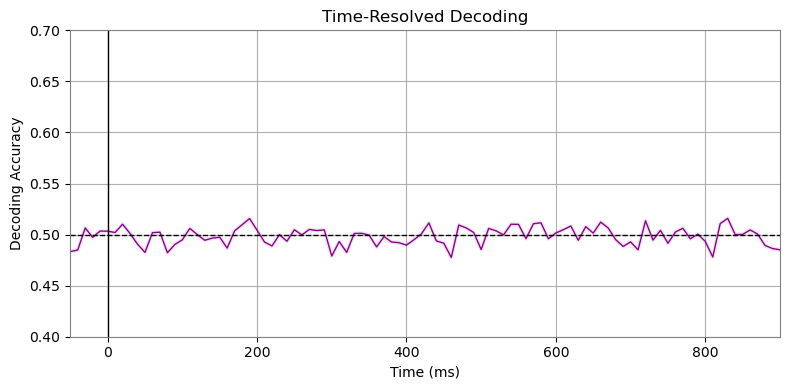

In [39]:
# List to store average accuracy values for each matrix
average_accuracies = []

# Loop through each accuracy matrix in 'all_accuracy_matrices'
for accuracy_df in all_accuracy_matrices:
    # Convert the DataFrame to a NumPy array, ignore NaN values, and calculate the mean
    matrix_values = accuracy_df.to_numpy()
    avg_accuracy = np.nanmean(matrix_values)  # np.nanmean ignores NaN values
    average_accuracies.append(avg_accuracy)

# Display the average accuracies
print("Average accuracy for each matrix:", average_accuracies)

# Plot time-resolved decoding accuracy
# Figure
time_vector = np.arange(min_time, max_time+2, 2*window_size)

plt.figure(figsize=(8, 4))
plt.plot(time_vector, average_accuracies, color='darkmagenta', alpha = 0.1, linewidth=3)
plt.plot(time_vector, average_accuracies, color='darkmagenta', alpha = 1, linewidth=1)
plt.axhline(0.5, color='black', linestyle='--', linewidth=1)  # 50% chance line
plt.axvline(0, color='black', linestyle='-', linewidth=1)  # Add a vertical line at t=0
plt.xlabel("Time (ms)")
plt.ylabel("Decoding Accuracy")
plt.title("Time-Resolved Decoding")

plt.xlim(-50, 900)  # Set x-axis limits
plt.ylim(0.4, 0.7)  # Set x-axis limits

# Set the box line color to gray
ax = plt.gca()
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.grid()
plt.tight_layout()
plt.show()

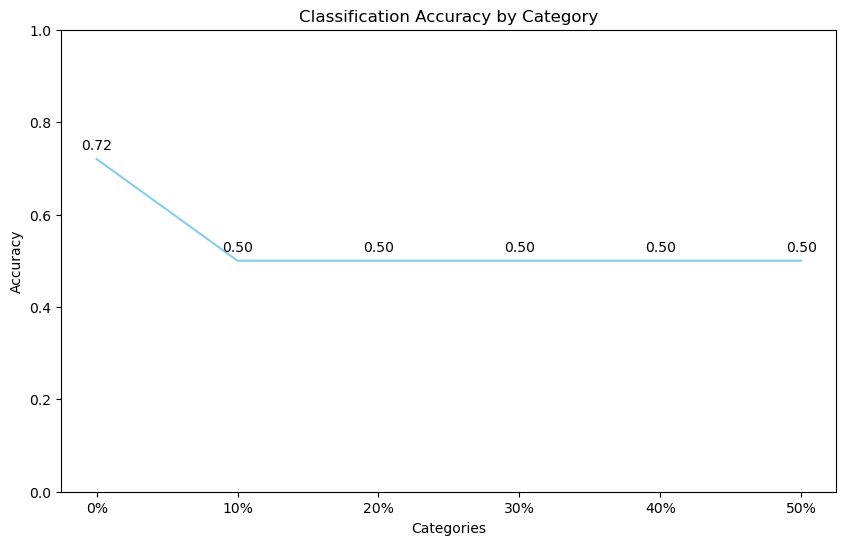

In [ ]:
# Define the data
categories = ['0%', '10%', '20%', '30%', '40%', '50%']
accuracies = [0.72, 0.5, 0.5, 0.5, 0.5, 0.5]  # Example accuracy values for each category

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.plot(categories, accuracies, color='skyblue')

# Add title and labels
plt.title('Concept response curve')
plt.xlabel('Proprtions of incorrect labeling')
plt.ylabel('Classification accuracy')
plt.ylim(0, 1)  # Setting y-axis limit to 0-1 for percentage scale

# Display values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center')

# Show the plot
plt.show()